In [37]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Load Data

In [38]:
data_dir = '/Users/nora/Box/dssg/DrivenData/Heart/data/'

In [39]:
test = pd.read_csv(data_dir + 'test_values.csv')
train = pd.read_csv(data_dir + 'train_values.csv')
labels = pd.read_csv(data_dir + 'train_labels.csv')

In [40]:
npatients = len(train)

# Prepare Data

In [41]:
def convert_columns(df, cols=[]):
    for col in cols:
        df[col] = df[col].astype(str)
    return df
        
def standardize(df, numeric_only=True):
    numeric = df.select_dtypes(include=['int64', 'float64'])
    
    # subtracy mean and divide by std
    df[numeric.columns] = (numeric - numeric.mean()) / numeric.std()
    
    return df

def pre_process_data(df, enforce_cols=None):
    print("Input shape:\t{}".format(df.shape))
        

    df = standardize(df)
    print("After standardization {}".format(df.shape))
        
    # create dummy variables for categoricals
    df = pd.get_dummies(df)
    print("After converting categoricals:\t{}".format(df.shape))
    

    # match test set and training set columns
    if enforce_cols is not None:
        to_drop = np.setdiff1d(df.columns, enforce_cols)
        to_add = np.setdiff1d(enforce_cols, df.columns)

        df.drop(to_drop, axis=1, inplace=True)
        df = df.assign(**{c: 0 for c in to_add})
    
    df.fillna(0, inplace=True)
    
    return df

## Prepare Train

In [42]:
patient_id = train['patient_id'].as_matrix()
train = train.drop('patient_id', axis=1)
train = convert_columns(train, cols=['chest_pain_type', 'resting_ekg_results'])
train = pre_process_data(train)

Input shape:	(180, 13)
After standardization (180, 13)
After converting categoricals:	(180, 20)


In [43]:
train.head()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,thal_fixed_defect,thal_normal,thal_reversible_defect,chest_pain_type_1,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,resting_ekg_results_0,resting_ekg_results_1,resting_ekg_results_2
0,-0.888762,-0.194652,-0.716404,-0.437019,1.115158,-0.900694,0.670152,-1.051032,0.929891,-0.678852,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.727169,-1.252825,-0.716404,-0.437019,-0.667915,0.526148,-1.483908,-0.086892,0.386007,-0.678852,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.888762,-0.371014,2.378462,-0.437019,1.039283,-0.900694,0.670152,2.377024,0.567302,1.464891,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.888762,1.216246,-0.716404,-0.437019,-0.497195,-0.900694,0.670152,-1.586666,1.428452,-0.678852,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,2.343100,2.744719,-0.716404,-0.437019,0.394342,2.844768,0.670152,0.448742,-0.203201,-0.678852,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


## Prepare Labels

In [44]:
labels = np.ravel(labels.drop('patient_id', axis=1))

## Prepare Test

In [45]:
test_patient_id = test['patient_id'].as_matrix()
test = test.drop('patient_id', axis=1)
test = convert_columns(test, cols=['chest_pain_type', 'resting_ekg_results'])
test = pre_process_data(test)

Input shape:	(90, 13)
After standardization (90, 13)
After converting categoricals:	(90, 20)


## Split Data

In [46]:
train1, train2, labels1, labels2 = train_test_split(train, labels, train_size=0.75, test_size=0.25, shuffle=True)

# Prepare Submission

In [47]:
def prepare_submission(model, test, fname='submission.csv'):
    probs = model.predict_proba(test)
    sub = pd.DataFrame(np.vstack([test_patient_id, probs[:,1]]).T)
    sub.to_csv(fname, sep=',', header=['patient_id','heart_disease_present'], index=False)

In [48]:
def get_score(model, test, labels, printing=True):
    probs = model.predict_proba(test)
    preds = model.predict(test)
    if printing:
        print 'Accuracy: %.2f' %(model.score(test, labels)) # %(len(np.where(preds == labels))/len(preds))
        print 'Log loss: %.2f' %(log_loss(labels, probs))
    return log_loss(labels, probs)

# Extra Trees Classifier

In [106]:
# random forests are often a good model to try first, especially when we have numeric and categorical variables in our feature space.
def train_etc(features, labels, **kwargs):
    
    # instantiate model
    # model = RandomForestClassifier(n_estimators=50, random_state=0)
    model = ExtraTreesClassifier(n_estimators=50, random_state=0)
    
    # train model
    model.fit(features, labels)
    
    # get a (not-very-useful) sense of performance
    accuracy = model.score(features, labels)
    # print(f"In-sample accuracy: {accuracy:0.2%}")
    # print("In-sample accuracy: %.2f percent" %(accuracy*100))
    
    return model

In [107]:
model = train_etc(train1, labels1)

In [108]:
preds = model.predict(train2)
probs = model.predict_proba(train2)

In [109]:
print 'Accuracy: %.2f' %(model.score(train2, labels2))
print 'Log loss: %.2f' %(log_loss(labels2, probs))

Accuracy: 0.87
Log loss: 0.42


In [110]:
model = train_etc(train, labels)

In [111]:
probs = model.predict_proba(test)
preds = model.predict(test)

In [112]:
sub = pd.DataFrame(np.vstack([test_patient_id, probs[:,1]]).T)

In [113]:
sub.to_csv('submission1.csv', sep=',', header=['patient_id','heart_disease_present'], index=False)

In [114]:
prepare_submission(model, test, 'submission.csv')

# Random Forest Classifier

In [96]:
# random forests are often a good model to try first, especially when we have numeric and categorical variables in our feature space.
def train_rfc(features, labels, **kwargs):
    
    # instantiate model
    model = RandomForestClassifier(n_estimators=50, random_state=0)
    
    # train model
    model.fit(features, labels)
    
    # get a (not-very-useful) sense of performance
    accuracy = model.score(features, labels)
    # print(f"In-sample accuracy: {accuracy:0.2%}")
    # print("In-sample accuracy: %.2f percent" %(accuracy*100))
    
    return model

In [97]:
model = train_rfc(train1, labels1)

In [98]:
_ = get_score(model, train2, labels2)

Accuracy: 0.82
Log loss: 1.12


# Compare RF and ET

In [103]:
rfc = RandomForestClassifier(n_estimators=50, random_state=12)
ext = ExtraTreesClassifier(n_estimators=50, random_state=12)

In [105]:
from sklearn.model_selection import cross_validate

cv_rfc = cross_validate(rfc, train, labels, cv=10, return_train_score=False)
print cv_rfc['test_score']

cv_ext = cross_validate(ext, train, labels, cv=10, return_train_score=False)
print cv_ext['test_score']

print
print np.mean(cv_rfc['test_score'])
print np.mean(cv_ext['test_score'])

print 'ExtraTrees wins'

[ 0.83333333  0.72222222  0.77777778  0.94444444  0.88888889  0.83333333
  0.88888889  0.72222222  0.66666667  0.83333333]
[ 0.83333333  0.66666667  0.88888889  1.          0.88888889  0.94444444
  0.83333333  0.77777778  0.72222222  0.83333333]

0.811111111111
0.838888888889
ExtraTrees wins


# Recursive Feature Elimination

In [62]:
rfc = RandomForestClassifier(n_estimators=50, random_state=12)
rfe = RFE(rfc, n_features_to_select=13)
rfe = rfe.fit(train, labels)

In [63]:
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)
idx_rank = np.argsort(rfe.ranking_)

[ True  True  True False  True  True  True  True  True  True False  True
  True False False False  True False False  True]
[1 1 1 6 1 1 1 1 1 1 7 1 1 2 5 4 1 3 8 1]


In [64]:
idx = np.where(rfe.support_==False)[0]
cols = train.keys()
cols[idx]

Index([u'fasting_blood_sugar_gt_120_mg_per_dl', u'thal_fixed_defect',
       u'chest_pain_type_1', u'chest_pain_type_2', u'chest_pain_type_3',
       u'resting_ekg_results_0', u'resting_ekg_results_1'],
      dtype='object')

In [65]:
for i, c in enumerate(cols[idx_rank]):
    print rfe.ranking_[idx_rank][i], c

1 slope_of_peak_exercise_st_segment
1 chest_pain_type_4
1 thal_reversible_defect
1 thal_normal
1 max_heart_rate_achieved
1 age
1 exercise_induced_angina
1 oldpeak_eq_st_depression
1 serum_cholesterol_mg_per_dl
1 num_major_vessels
1 resting_blood_pressure
1 sex
1 resting_ekg_results_2
2 chest_pain_type_1
3 resting_ekg_results_0
4 chest_pain_type_3
5 chest_pain_type_2
6 fasting_blood_sugar_gt_120_mg_per_dl
7 thal_fixed_defect
8 resting_ekg_results_1


In [66]:
train.head()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,thal_fixed_defect,thal_normal,thal_reversible_defect,chest_pain_type_1,chest_pain_type_2,chest_pain_type_3,chest_pain_type_4,resting_ekg_results_0,resting_ekg_results_1,resting_ekg_results_2
0,-0.888762,-0.194652,-0.716404,-0.437019,1.115158,-0.900694,0.670152,-1.051032,0.929891,-0.678852,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.727169,-1.252825,-0.716404,-0.437019,-0.667915,0.526148,-1.483908,-0.086892,0.386007,-0.678852,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,-0.888762,-0.371014,2.378462,-0.437019,1.039283,-0.900694,0.670152,2.377024,0.567302,1.464891,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,-0.888762,1.216246,-0.716404,-0.437019,-0.497195,-0.900694,0.670152,-1.586666,1.428452,-0.678852,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,2.343100,2.744719,-0.716404,-0.437019,0.394342,2.844768,0.670152,0.448742,-0.203201,-0.678852,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [67]:
train.loc[:, rfe.support_].head()

,slope_of_peak_exercise_st_segment,resting_blood_pressure,num_major_vessels,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,thal_normal,thal_reversible_defect,chest_pain_type_4,resting_ekg_results_2
0,-0.888762,-0.194652,-0.716404,1.115158,-0.900694,0.670152,-1.051032,0.929891,-0.678852,1.0,0.0,0.0,1.0
1,0.727169,-1.252825,-0.716404,-0.667915,0.526148,-1.483908,-0.086892,0.386007,-0.678852,1.0,0.0,0.0,0.0
2,-0.888762,-0.371014,2.378462,1.039283,-0.900694,0.670152,2.377024,0.567302,1.464891,1.0,0.0,1.0,1.0
3,-0.888762,1.216246,-0.716404,-0.497195,-0.900694,0.670152,-1.586666,1.428452,-0.678852,0.0,1.0,1.0,0.0
4,2.343100,2.744719,-0.716404,0.394342,2.844768,0.670152,0.448742,-0.203201,-0.678852,0.0,1.0,0.0,1.0


In [68]:
model = train_rfc(train1.loc[:, rfe.support_], labels1)

In [69]:
get_score(model, train2.loc[:, rfe.support_], labels2)

Accuracy: 0.82
Log loss: 0.41


0.40938270662325965

In [70]:
model = train_rfc(train.loc[:, rfe.support_], labels)

In [71]:
prepare_submission(model, test.loc[:, rfe.support_], 'submission4.csv')

In [75]:
# figure out best fit n features

# llmin = np.inf
# rfc = RandomForestClassifier(n_estimators=50, random_state=12)
# for n_feat in range(1,train.shape[1]+1):
#     print
#     rfe = RFE(rfc, n_features_to_select=n_feat)
#     rfe = rfe.fit(train, labels)
#     model = train_rfc(train1.loc[:, rfe.support_], labels1)
#     logloss = get_score(model, train2.loc[:, rfe.support_], labels2)
#     if logloss < llmin:
#         llmin = logloss
#         print 'New best score with n_feat = %i' %n_feat

In [76]:
# figure out best fit n features, average over 10 CV sets

# llmin = np.inf
# rfc = RandomForestClassifier(n_estimators=50, random_state=12)
# for n_feat in range(1,train.shape[1]+1):
#     print 'n_feat = %i' %n_feat
#     score = 0.
#     for i in range(10):
#         # print score
#         train1, train2, labels1, labels2 = train_test_split(train, labels, train_size=0.75, test_size=0.25, shuffle=True)
#         # print
#         rfe = RFE(rfc, n_features_to_select=n_feat)
#         rfe = rfe.fit(train1, labels1)
#         model = train_rfc(train1.loc[:, rfe.support_], labels1)
#         logloss = get_score(model, train2.loc[:, rfe.support_], labels2, printing=False)
#         score += logloss
#     print score/11.
#     if score < llmin:
#         llmin = score
#         print 'New best score with n_feat = %i' %n_feat

# TSNE

In [77]:
from sklearn.manifold import TSNE

In [78]:
X = TSNE(n_components=2).fit_transform(train)

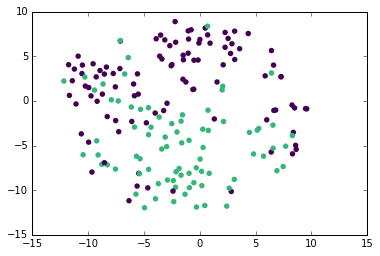

In [79]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', edgecolor='none', vmax=1.5, s=30)

# Logistic Regression

In [80]:
from sklearn.linear_model import LogisticRegression

In [81]:
logreg = LogisticRegression()
params = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]}

In [82]:
from sklearn.model_selection import GridSearchCV
logreg_gs = GridSearchCV(logreg, params, cv=10, return_train_score=True)
logreg_gs.fit(train, labels)

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [83]:
print 'Best params: ', logreg_gs.best_params_
best_lr = logreg_gs.best_estimator_
coefs = best_lr.coef_
print 'Best number of features: ', coefs.size
print 'Number of selected features: %i' %np.count_nonzero(coefs)

Best params:  {'penalty': 'l2', 'C': 0.01}
Best number of features:  20
Number of selected features: 20


In [84]:
print 'Best accuracy: %.2f' %(logreg_gs.best_score_ * 100)
print 'Best parameters: ', logreg_gs.best_params_

Best accuracy: 84.44
Best parameters:  {'penalty': 'l2', 'C': 0.01}


In [85]:
prepare_submission(logreg_gs, test, fname='submission_logreg_gs.csv')